In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *

import numpy as np
from numpy.testing import assert_array_almost_equal as aae

from scipy.linalg import cossin, block_diag

from functools import reduce
tensor_product = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

In [2]:
### Define Useful Matrices

X = XGate().to_matrix()
Y = YGate().to_matrix()
Z = ZGate().to_matrix()

Rx = lambda theta: RXGate(theta).to_matrix()
Ry = lambda theta: RYGate(theta).to_matrix()
Rz = lambda theta: RZGate(theta).to_matrix()

Implement  using the [Schmidt Decomposition](https://arxiv.org/pdf/1003.5760.pdf)

### Build Multiplex $R_k$ gates (Theorem 8)

In [3]:
def multiplex_cry(circ, angles, control_bit = 0, flip = False): # Build optimized multiplexed cry gate
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.ry(angles[0], no_qubits-1)
        circ.cz(no_qubits-2, no_qubits-1)
        circ.ry(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cz(no_qubits-2, no_qubits-1)  
            
        return None
                
    elif len_angles == 2 and flip: ### Base case with Optimzation
        circ.ry(angles[1], no_qubits-1)
        circ.cz(no_qubits-2, no_qubits-1)
        circ.ry(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_cry(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cz(control_bit, no_qubits - 1)
        multiplex_cry(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cz(control_bit, no_qubits - 1)

def multiplex_crz(circ, angles, control_bit = 0, flip = False):
    
    """
    Build optimized multiplexed crz gate
    
    Parameters
    ----------
    circ : QuantumCircuit
        The circuit to which the multiplexed crz gate is applied.
    
    angles : list
        The list of angles to be applied to the multiplexed crz gate.
    
    control_bit : int
        The control bit for the multiplexed crz gate.
    
    flip : bool
        A boolean to determine whether the multiplexed crz gate is flipped or not.
    
    Returns
    -------
    None
        The multiplexed crz gate is applied to the circuit.
    """
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.rz(angles[0], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cx(no_qubits-2, no_qubits-1)
            
        return None
    
    elif len_angles == 2 and flip: ### Base case with Optimzation
        
        circ.rz(angles[1], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_crz(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cx(control_bit, no_qubits - 1)
        multiplex_crz(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cx(control_bit, no_qubits - 1)

### Modified Angles as Linear Combinations

In [4]:
def modified_angles(angles):
    hadamard = np.array([[1, 1], [1, -1]])
    
    dim = int(np.log2(len(angles)))
    coef_mat = tensor_product(*[hadamard]*dim) # Tensor Product of Hadamard
    modified_angles = angles@coef_mat / 2**dim
    
    return modified_angles

### Test Implementation of Theorem 8

In [5]:
no_qubits = 3

m = 2**(no_qubits-1)
angles = [1, 2, 3, 4]

circ = QuantumCircuit(no_qubits)
multiplex_cry(circ, modified_angles(angles))

aae(Operator(circ.reverse_bits()).data, block_diag(*[Ry(angle) for angle in angles]))

#circ.reverse_bits().draw('mpl')

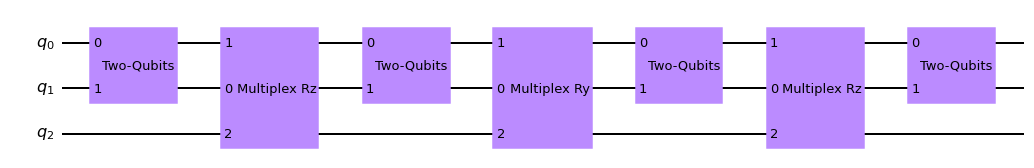

In [12]:
circ.draw("mpl")

### Implementing General Unitary Operator

In [7]:
def one_level_decomp(U): 
    
    '''Perform Matrix Shannon-Decomposition''' 
    
    n = int(np.log2(len(U)))

    ### Decompose U (Eq. 1)
    B, CS, A = cossin(U, p=2**(n-1), q=2**(n-1))
    A1, A2 = A[:2**(n-1), :2**(n-1)], A[2**(n-1):, 2**(n-1):]
    B1, B2 = B[:2**(n-1), :2**(n-1)], B[2**(n-1):, 2**(n-1):]
    
    ### Decompose B  (Eq. 2)
    U4, DB = diagonalize(B1@dagger(B2))
    DB = np.sqrt(DB)
    U3 = DB@dagger(U4)@B2

    ### Decompose A  (Eq. 2)
    U2, DA = diagonalize(A1@dagger(A2))
    DA = np.sqrt(DA)
    U1 = DA@dagger(U2)@A2
    
    return U4, DB, U3, CS, U2, DA, U1

In [8]:
### Helpful Linear Algebra Functions

def diagonalize(mat):
    
    '''Function to Diagonalize Square Matrices'''
    
    eig_val, eig_vec = np.linalg.eig(mat)
    D = np.diag(eig_val)
    V = np.block(eig_vec)
    
    return V, D

dagger = lambda mat: np.conj(mat).T  # Conjugate Transpose of a Matrix

In [9]:
def QSD(circ, unitary_matrix, iteration_qubits):
    
    """
    Quantum Subroutine for Quantum Shannon Decomposition
    
    This function takes a unitary matrix and decomposes it into a sequence of CX and single qubit gates.
    The decomposition is done using the Quantum Shannon Decomposition algorithm.
    
    Parameters
    ----------
    circ : QuantumCircuit
        The circuit to which the decomposition is to be applied.
    unitary_matrix : numpy.ndarray
        The unitary matrix to be decomposed.
    iteration_qubits : int
        The number of qubits in the circuit.
        
    Returns
    -------
    None
    
    """
    
    if circ.num_qubits == 1: ### Non-recursion Base Case
        circ.unitary(unitary_matrix, 0)
        return None
    
    elif circ.num_qubits == 2 or iteration_qubits == 2: ### Non-recursion Base Case
        circ.unitary(unitary_matrix, [0, 1], 'Two-Qubits')
        return None
    
    else:
        
        U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(unitary_matrix)

        QSD(circ, U1, iteration_qubits-1)

        angles_DA = modified_angles(np.angle(np.diag(DA))*-2)
        
        DA_circ = QuantumCircuit(iteration_qubits)
        multiplex_crz(DA_circ, angles_DA)
        DA_circ.name = ' Multiplex Rz'
        circ.append(DA_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])
        
        QSD(circ, U2, iteration_qubits-1)

        size = int(np.log2(len(CS)))
        angles_CS = modified_angles(np.array([np.arctan2(CS[2**(size-1) + i, i], CS[i, i])*2 for i in range(2**(size-1))]))
        CS_circ = QuantumCircuit(iteration_qubits)
        multiplex_cry(CS_circ, angles_CS)
        CS_circ.name = ' Multiplex Ry'
        circ.append(CS_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])

        QSD(circ, U3, iteration_qubits-1)

        angles_DB = modified_angles(np.angle(np.diag(DB))*-2)
        DB_circ = QuantumCircuit(iteration_qubits)
        multiplex_crz(DB_circ, angles_DB)
        DB_circ.name = ' Multiplex Rz'
        circ.append(DB_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])

        QSD(circ, U4, iteration_qubits-1)

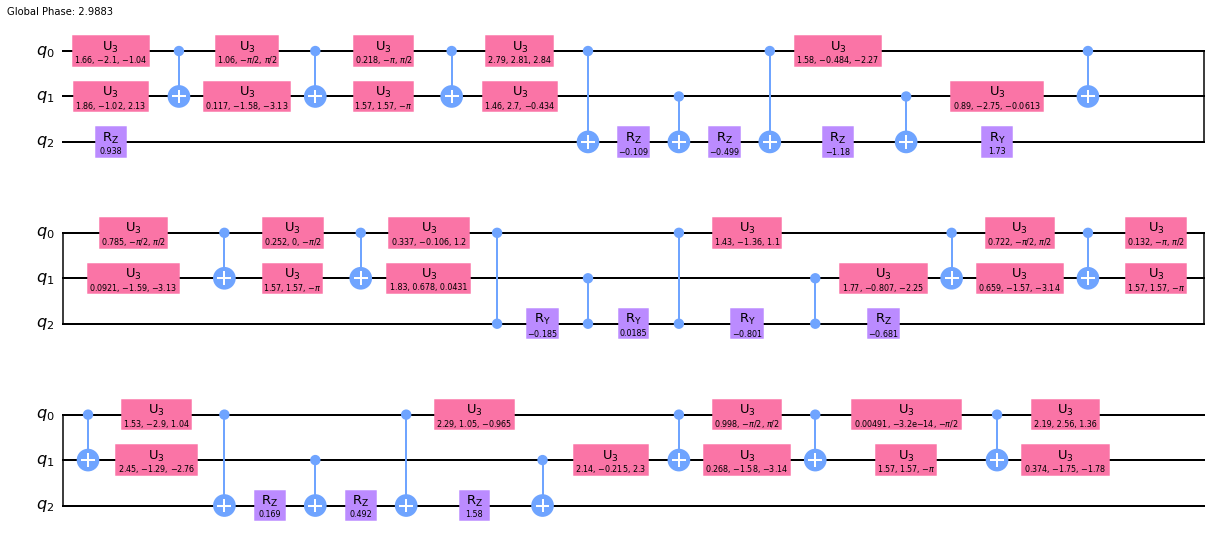

In [10]:
no_qubits = 3
unitary_matrix = random_unitary(2**no_qubits).data

circ = QuantumCircuit(no_qubits)
QSD(circ, unitary_matrix, no_qubits)
circ.decompose().draw("mpl")